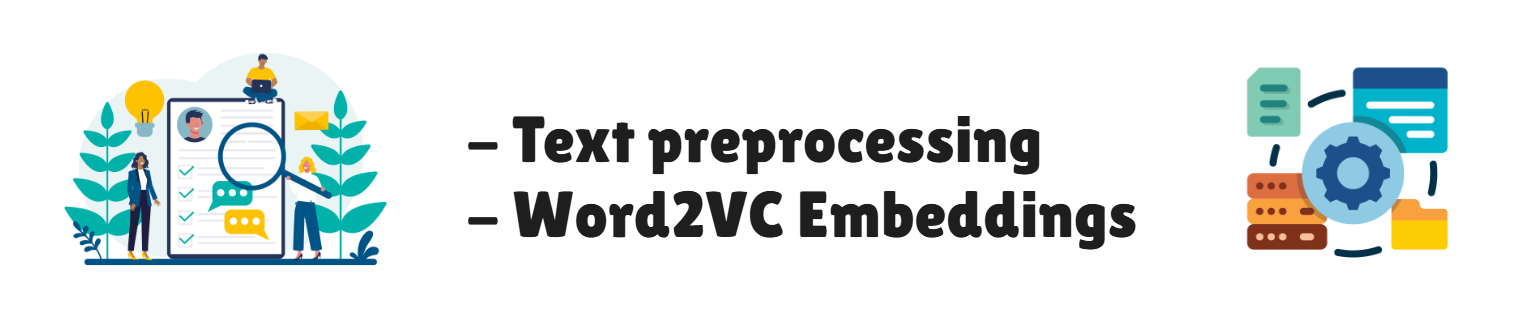

This notebook explores the **Resume Dataset** to analyze and compare different word embedding techniques for NLP tasks. We'll process resume text data and evaluate three popular embedding methods: **Skip-gram**, **CBOW**, and **BERT** to determine which approach best captures semantic relationships in professional resume content.
<br>

---

# Summary

1. **Exploratory Data Analysis (EDA)**
2. **Text Preprocessing Pipeline**
3. **Train Word2Vec Models (CBOW and Skip-gram)**
4. **Models Evaluation**


-----

# 1- Exploratory Data Analysis
-----


**Why it matters:** 🔍  
- Reveals dataset characteristics (size, distribution, class balance)
- Identifies potential data quality issues (missing values, duplicates, noise)
- Helps us understand vocabulary diversity and text length patterns
- Determines if the dataset has sufficient variation for meaningful embeddings
- Guides preprocessing decisions based on observed patterns


## 1️⃣ Library Imports 

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# NLP Libraries
import nltk
import re
import string
from collections import Counter
from wordcloud import WordCloud

# NLTK specific imports
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

# For Google Colab
from IPython.display import HTML, display

# Download required NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

# Configure plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## 2️⃣ Data Loading


In [2]:
# =============================================================================
# 📁 DATA LOADING & EXPLORATION
# =============================================================================
df = pd.read_csv('/kaggle/input/resume-dataset/UpdatedResumeDataSet.csv')
def load_resume_dataset():
    """Load the resume dataset from CSV file"""
    try:
        print("📂 Loading UpdatedResumeDataSet.csv...")
        df = pd.read_csv('/kaggle/input/resume-dataset/UpdatedResumeDataSet.csv')
        df.head()
        print(f"✅ Dataset loaded successfully! Shape: {df.shape}")
        return df
    except FileNotFoundError:
        print("❌ Error: File 'UpdatedResumeDataSet.csv' not found!")
        print("💡 Make sure you have:")
        print("   1. Downloaded the dataset using kaggle API")
        print("   2. Unzipped the file")
        print("   3. The CSV file is in the current directory")
        return None
    except Exception as e:
        print(f"❌ Error loading file: {e}")
        return None
load_resume_dataset()

📂 Loading UpdatedResumeDataSet.csv...
✅ Dataset loaded successfully! Shape: (962, 2)


,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."
...,...,...
957,Testing,Computer Skills: â¢ Proficient in MS office (...
958,Testing,â Willingness to accept the challenges. â ...
959,Testing,"PERSONAL SKILLS â¢ Quick learner, â¢ Eagerne..."
960,Testing,COMPUTER SKILLS & SOFTWARE KNOWLEDGE MS-Power ...


## 3️⃣ Dataset overview

In [3]:
def display_html_overview(df, dataset_name="Dataset"):
    """
    Create and display HTML-formatted dataset overview.

    Args:
        df (pd.DataFrame): Input dataset
        dataset_name (str): Name of the dataset
    """
    # Calculate statistics
    num_rows = len(df)
    num_cols = len(df.columns)

    # Category distribution if available
    category_info = ""
    if 'Category' in df.columns:
        num_categories = df['Category'].nunique()
        category_info = f"""
        <p style="margin: 10px 0;"><strong style="color: #666;">Number of Categories:</strong>
           <span style="color: #2196F3; font-weight: bold;">{num_categories}</span></p>
        """

    html_content = f"""
    <div style="background-color: #f0f8ff; padding: 20px; border-radius: 10px;
                box-shadow: 0 2px 4px rgba(0,0,0,0.1); font-family: Arial, sans-serif;
                margin: 20px 0;">
        <h2 style="color: #2196F3; margin-top: 0;">📊 {dataset_name} Overview</h2>
        <div style="line-height: 1.8; color: #555;">
            <p style="margin: 10px 0;"><strong style="color: #666;">Number of Rows:</strong>
               <span style="color: #2196F3; font-weight: bold;">{num_rows:,}</span></p>
            <p style="margin: 10px 0;"><strong style="color: #666;">Number of Columns:</strong>
               <span style="color: #2196F3; font-weight: bold;">{num_cols}</span></p>
            {category_info}
            <p style="margin: 10px 0;"><strong style="color: #666;">Memory Usage:</strong>
               <span style="color: #2196F3; font-weight: bold;">
               {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB</span></p>
    """

    # Add column information
    html_content += """
        <p style="margin: 15px 0 10px 0;"><strong style="color: #666;">Column Information:</strong></p>
        <ul style="margin: 5px 0; padding-left: 30px;">
    """

    for col in df.columns:
        null_count = df[col].isnull().sum()
        null_pct = (null_count / num_rows) * 100
        dtype = str(df[col].dtype)

        # Add unique count for categorical columns
        if df[col].dtype == 'object' and col != 'Resume':
            unique_count = df[col].nunique()
            unique_info = f" - {unique_count} unique values"
        else:
            unique_info = ""

        if null_count > 0:
            html_content += f"""
            <li style="margin: 5px 0; color: #555;">
                <strong>{col}</strong> ({dtype}){unique_info} -
                <span style="color: #f44336;">{null_count:,} missing ({null_pct:.1f}%)</span>
            </li>
            """
        else:
            html_content += f"""
            <li style="margin: 5px 0; color: #555;">
                <strong>{col}</strong> ({dtype}){unique_info} -
                <span style="color: #4CAF50;">✓ No missing values</span>
            </li>
            """

    html_content += """
        </ul>
    </div>
    """

    display(HTML(html_content))

display_html_overview(df, "Resume Dataset")

## 4️⃣ Categories Distribution 

In [25]:

def analyze_categories(df, category_column='Category'):
    """
    Analyze category distribution.

    Args:
        df (pd.DataFrame): Input dataset
        category_column (str): Name of the category column
    """
    if category_column not in df.columns:
        return

    category_counts = df[category_column].value_counts()

    html_content = """
    <div style="background-color: #e8f5e9; padding: 20px; border-radius: 8px;
                border-left: 4px solid #4CAF50; margin: 15px 0;
                font-family: Arial, sans-serif;">
        <h4 style="color: #2e7d32; margin-top: 0;">🎯 Category Distribution</h4>
        <div style="display: grid; grid-template-columns: repeat(auto-fill, minmax(200px, 1fr)); gap: 10px;">
    """

    for category, count in category_counts.items():
        percentage = (count / len(df)) * 100
        html_content += f"""
        <div style="background-color: white; padding: 12px; border-radius: 5px;
                    box-shadow: 0 1px 3px rgba(0,0,0,0.1);">
            <strong style="color: #2e7d32;">{category}</strong><br>
            <span style="font-size: 18px; font-weight: bold; color: #4CAF50;">{count}</span>
            <span style="color: #666; font-size: 12px;">({percentage:.1f}%)</span>
        </div>
        """

    html_content += """
        </div>
    </div>
    """

    display(HTML(html_content))
    
# =============================================================================
# 🔍 MAIN EXECUTION
# =============================================================================

print("\n" + "="*60)
print("🚀 STARTING RESUME DATASET ANALYSIS")
print("="*60 + "\n")

df.head()

# Load data
df = load_resume_dataset()

if df is not None:
    # Display overview
    print("\n📄 RESUME DATASET EXPLORATION")
    print("="*60)
    

    # Analyze categories
    if 'Category' in df.columns:
        analyze_categories(df, 'Category')

    # =============================================================================
    # 📊 VISUALIZATIONS
    # =============================================================================

    print("\n📊 Creating Visualizations...")


    if 'Category' in df.columns:
        category_counts = df['Category'].value_counts()
        # 2. Category Distribution Pie Chart
        fig2 = go.Figure(data=[
            go.Pie(
                labels=category_counts.index,
                values=category_counts.values,
                hole=0.3,
                textinfo='label+percent',
                textposition='outside',
                marker=dict(colors=px.colors.qualitative.Set3)
            )
        ])

        fig2.update_layout(
            title="🎯 Category Distribution (Percentage)",
            height=600,
            showlegend=True
        )

        fig2.show()

    # 3. Text Length Distribution
    if 'Resume' in df.columns:
        df['Resume_length'] = df['Resume'].astype(str).str.len()
        df['Resume_words'] = df['Resume'].astype(str).str.split().str.len()

        fig3 = make_subplots(
            rows=1, cols=2,
            subplot_titles=('Character Length Distribution', 'Word Count Distribution')
        )

        fig3.add_trace(
            go.Histogram(
                x=df['Resume_length'],
                name='Character Length',
                marker_color='lightblue',
                opacity=0.7,
                nbinsx=30
            ),
            row=1, col=1
        )

        fig3.add_trace(
            go.Histogram(
                x=df['Resume_words'],
                name='Word Count',
                marker_color='lightcoral',
                opacity=0.7,
                nbinsx=30
            ),
            row=1, col=2
        )

    # =============================================================================
    # 📈 ADDITIONAL INSIGHTS
    # =============================================================================

    print("\n📈 Generating Additional Insights...")

    if 'Resume' in df.columns and 'Category' in df.columns:
        # Top keywords by category
        stop_words = set(stopwords.words('english'))

        category_keywords = {}
        for category in df['Category'].unique():
            category_text = ' '.join(df[df['Category'] == category]['Resume'].astype(str).values)
            words = category_text.lower().split()
            filtered_words = [word for word in words if word not in stop_words and len(word) > 3]
            word_freq = Counter(filtered_words)
            category_keywords[category] = word_freq.most_common(10)

        # Display top keywords in HTML
        html_content = """
        <div style="background-color: #f3e5f5; padding: 20px; border-radius: 8px;
                    border-left: 4px solid #9C27B0; margin: 15px 0;
                    font-family: Arial, sans-serif;">
            <h4 style="color: #6a1b9a; margin-top: 0;">🔑 Top Keywords by Category</h4>
        """

        for category, keywords in list(category_keywords.items())[:5]:
            html_content += f"""
            <div style="background-color: white; padding: 12px; margin: 10px 0;
                        border-radius: 5px; box-shadow: 0 1px 3px rgba(0,0,0,0.1);">
                <strong style="color: #9C27B0; font-size: 16px;">{category}</strong><br>
                <span style="color: #666; font-size: 14px;">
            """

            keyword_list = ', '.join([f"{word} ({count})" for word, count in keywords[:10]])
            html_content += keyword_list

            html_content += """
                </span>
            </div>
            """

        html_content += """
        </div>
        """

        display(HTML(html_content))

    print("\n✅ Analysis Complete!")
    print("="*60)

else:
    print("❌ Failed to load dataset. Please check the file path.")


🚀 STARTING RESUME DATASET ANALYSIS

📂 Loading UpdatedResumeDataSet.csv...
✅ Dataset loaded successfully! Shape: (962, 2)

📄 RESUME DATASET EXPLORATION



📊 Creating Visualizations...



📈 Generating Additional Insights...



✅ Analysis Complete!


-----

# 2- Text Preprocessing
-----

**Why it matters:** 🧹  
Text preprocessing is the foundation of any NLP task. Raw text contains noise that can degrade model performance. By standardizing and cleaning the text, we:
- Reduce vocabulary size and computational complexity
- Remove irrelevant features (punctuation, numbers, special characters)
- Normalize text for consistent model input
- Focus on meaningful linguistic units through tokenization and lemmatization

<br>


**Pipeline Steps:**
- **Lowercase conversion** → Ensures consistency (e.g., "Python" = "python")
- **Remove punctuation, numbers & special chars** → Eliminates noise
- **Tokenization** → Splits text into individual words/tokens
- **Stopword removal** → Removes common words with little semantic value
- **Lemmatization** → Converts words to base form (e.g., "running" → "run")
- **Rejoin tokens** → Reconstructs clean text for embedding models

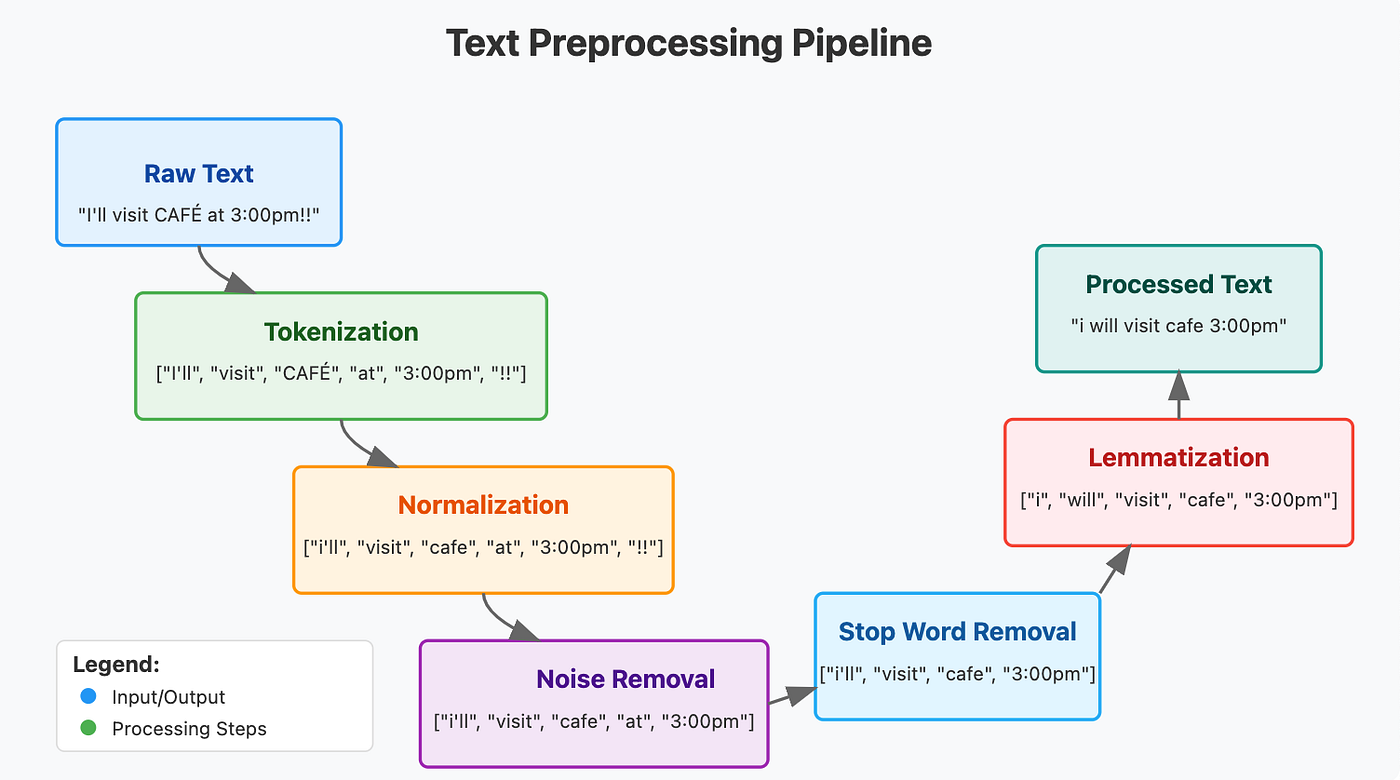

## 1️⃣ Data cleaning


In [6]:
def clean_text(text):
    """
    Clean text by:
    - Converting to lowercase
    - Removing URLs
    - Removing email addresses
    - Removing mentions (@username)
    - Removing punctuation
    - Removing extra whitespace
    """
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # Remove mentions (@username)
    text = re.sub(r'@\w+', '', text)
    
    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', ' ', text)
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Display sample resume text before preprocessing
print("\n" + "="*80)
print("📋 SAMPLE RESUME TEXT (BEFORE PREPROCESSING) 📋")
print("="*80)
print(df['Resume'].iloc[0][:500] + "...") 
# Apply cleaning
df['cleaned_text'] = df['Resume'].apply(clean_text)

print("\n" +"✅ Data Cleaning Complete")
print("\n" + "="*80)
print("✨ AFTER CLEANING ✨")
print("="*80)
print(df['cleaned_text'].iloc[0][:500] + "...")


📋 SAMPLE RESUME TEXT (BEFORE PREPROCESSING) 📋
Skills * Programming Languages: Python (pandas, numpy, scipy, scikit-learn, matplotlib), Sql, Java, JavaScript/JQuery. * Machine learning: Regression, SVM, NaÃ¯ve Bayes, KNN, Random Forest, Decision Trees, Boosting techniques, Cluster Analysis, Word Embedding, Sentiment Analysis, Natural Language processing, Dimensionality reduction, Topic Modelling (LDA, NMF), PCA & Neural Nets. * Database Visualizations: Mysql, SqlServer, Cassandra, Hbase, ElasticSearch D3.js, DC.js, Plotly, kibana, matplotlib...

✅ Data Cleaning Complete

✨ AFTER CLEANING ✨
skills programming languages python pandas numpy scipy scikit learn matplotlib sql java javascript jquery machine learning regression svm naã ve bayes knn random forest decision trees boosting techniques cluster analysis word embedding sentiment analysis natural language processing dimensionality reduction topic modelling lda nmf pca neural nets database visualizations mysql sqlserver cassandra hbase

## 2️⃣ Remove Stop Words

In [7]:
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    """
    Remove common English stop words from text
    """
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

# Apply stop word removal
df['no_stopwords'] = df['cleaned_text'].apply(remove_stopwords)

print("\n" +"✅ Stop Words Removed")
print(f"\nNumber of stop words: {len(stop_words)}")
print(f"Sample stop words: {list(stop_words)[:20]}")
print("\n" + "="*80)
print("✨ AFTER REMOVING STOP WORDS ✨")
print("="*80)
print(df['no_stopwords'].iloc[0][:500] + "...")


✅ Stop Words Removed

Number of stop words: 198
Sample stop words: ['themselves', 'below', 'o', 'couldn', 'himself', 'should', 'on', 'our', 't', "weren't", 'doesn', "she'd", 'but', "they'll", 'be', 'we', 'them', 'between', 'who', 'about']

✨ AFTER REMOVING STOP WORDS ✨
skills programming languages python pandas numpy scipy scikit learn matplotlib sql java javascript jquery machine learning regression svm naã bayes knn random forest decision trees boosting techniques cluster analysis word embedding sentiment analysis natural language processing dimensionality reduction topic modelling lda nmf pca neural nets database visualizations mysql sqlserver cassandra hbase elasticsearch js dc js plotly kibana matplotlib ggplot tableau others regular expression html css a...


## 3️⃣ Tokenization

In [8]:
def tokenize_text(text):
    """
    Split text into individual tokens (words)
    """
    tokens = word_tokenize(text)
    return tokens

# Apply tokenization
df['tokens'] = df['no_stopwords'].apply(tokenize_text)

print("\n" +"✅ Tokenization Complete")
print("\n" + "="*80)
print("✨ TOKENS (First Resume) ✨")
print("="*80)
print(f"Number of tokens: {len(df['tokens'].iloc[0])}")
print(f"First 50 tokens: {df['tokens'].iloc[0][:50]}")


✅ Tokenization Complete

✨ TOKENS (First Resume) ✨
Number of tokens: 501
First 50 tokens: ['skills', 'programming', 'languages', 'python', 'pandas', 'numpy', 'scipy', 'scikit', 'learn', 'matplotlib', 'sql', 'java', 'javascript', 'jquery', 'machine', 'learning', 'regression', 'svm', 'naã', 'bayes', 'knn', 'random', 'forest', 'decision', 'trees', 'boosting', 'techniques', 'cluster', 'analysis', 'word', 'embedding', 'sentiment', 'analysis', 'natural', 'language', 'processing', 'dimensionality', 'reduction', 'topic', 'modelling', 'lda', 'nmf', 'pca', 'neural', 'nets', 'database', 'visualizations', 'mysql', 'sqlserver', 'cassandra']


## 4️⃣ Lemmatization

In [9]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tokens):
    """
    Reduce tokens to their base/dictionary form
    Examples: running -> run, better -> good, caring -> care
    """
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized

# Apply lemmatization
df['lemmatized_tokens'] = df['tokens'].apply(lemmatize_tokens)

print("\n" +"✅ Lemmatization Complete")
print("\n" + "="*80)
print("✨ LEMMATIZED TOKENS (First Resume) ✨")
print("="*80)
print(f"Number of tokens: {len(df['lemmatized_tokens'].iloc[0])}")
print(f"First 50 lemmatized tokens: {df['lemmatized_tokens'].iloc[0][:50]}")

# Show comparison of original vs lemmatized
print("\n" + "="*80)
print("🚀 COMPARISON - Original vs Lemmatized 🚀")
print("="*80)
sample_tokens = df['tokens'].iloc[0][:20]
sample_lemmatized = df['lemmatized_tokens'].iloc[0][:20]
for orig, lemma in zip(sample_tokens, sample_lemmatized):
    if orig != lemma:
        print(f"  {orig} -> {lemma}")


✅ Lemmatization Complete

✨ LEMMATIZED TOKENS (First Resume) ✨
Number of tokens: 501
First 50 lemmatized tokens: ['skill', 'programming', 'language', 'python', 'panda', 'numpy', 'scipy', 'scikit', 'learn', 'matplotlib', 'sql', 'java', 'javascript', 'jquery', 'machine', 'learning', 'regression', 'svm', 'naã', 'bayes', 'knn', 'random', 'forest', 'decision', 'tree', 'boosting', 'technique', 'cluster', 'analysis', 'word', 'embedding', 'sentiment', 'analysis', 'natural', 'language', 'processing', 'dimensionality', 'reduction', 'topic', 'modelling', 'lda', 'nmf', 'pca', 'neural', 'net', 'database', 'visualization', 'mysql', 'sqlserver', 'cassandra']

🚀 COMPARISON - Original vs Lemmatized 🚀
  skills -> skill
  languages -> language
  pandas -> panda


## 5️⃣ Join Tokens Back to String

In [10]:
def join_tokens(tokens):
    """
    Combine tokens back into a single string
    """
    return ' '.join(tokens)

# Apply joining
df['preprocessed_text'] = df['lemmatized_tokens'].apply(join_tokens)

print("\n" +"✅ Tokens Joined Back to String")
print("\n" + "="*80)
print("📋 FINAL PREPROCESSED TEXT 📋")
print("="*80)
print(df['preprocessed_text'].iloc[0][:500] + "...")


✅ Tokens Joined Back to String

📋 FINAL PREPROCESSED TEXT 📋
skill programming language python panda numpy scipy scikit learn matplotlib sql java javascript jquery machine learning regression svm naã bayes knn random forest decision tree boosting technique cluster analysis word embedding sentiment analysis natural language processing dimensionality reduction topic modelling lda nmf pca neural net database visualization mysql sqlserver cassandra hbase elasticsearch j dc j plotly kibana matplotlib ggplot tableau others regular expression html cs angular log...


## 6️⃣ Final Comparison & saving preprocesed dataset

In [11]:
print("\n" + "="*80)
print("🚀 PREPROCESSING PIPELINE COMPLETE - SUMMARY 🚀")
print("="*80)

# Select a sample resume for comparison
sample_idx = 0

print("\n1. ORIGINAL TEXT (First 300 chars):")
print("-" * 80)
print(df['Resume'].iloc[sample_idx][:300] + "...")

print("\n2. AFTER CLEANING (First 300 chars):")
print("-" * 80)
print(df['cleaned_text'].iloc[sample_idx][:300] + "...")

print("\n3. AFTER STOP WORD REMOVAL (First 300 chars):")
print("-" * 80)
print(df['no_stopwords'].iloc[sample_idx][:300] + "...")

print("\n4. FINAL PREPROCESSED TEXT (First 300 chars):")
print("-" * 80)
print(df['preprocessed_text'].iloc[sample_idx][:300] + "...")

print("\n" + "="*80)
print("📊 STATISTICS 📊")
print("="*80)
print(f"Total resumes processed: {len(df)}")
print(f"\nAverage text length:")
print(f"  - Original: {df['Resume'].str.len().mean():.0f} characters")
print(f"  - Preprocessed: {df['preprocessed_text'].str.len().mean():.0f} characters")
print(f"  - Reduction: {(1 - df['preprocessed_text'].str.len().mean() / df['Resume'].str.len().mean()) * 100:.1f}%")

print(f"\nAverage tokens per resume:")
print(f"  - Before lemmatization: {df['tokens'].apply(len).mean():.0f}")
print(f"  - After lemmatization: {df['lemmatized_tokens'].apply(len).mean():.0f}")


# Cell 9: Save Preprocessed Data
# ============================================================================
# Save the preprocessed dataset
output_df = df[['Category', 'Resume', 'preprocessed_text']]
output_df.to_csv('preprocessed_resumes.csv', index=False)

print("\n 📂 Preprocessed data saved to 'preprocessed_resumes.csv' ✅")
print(f"\nColumns in output file: {output_df.columns.tolist()}")
print(f"Shape: {output_df.shape}")


🚀 PREPROCESSING PIPELINE COMPLETE - SUMMARY 🚀

1. ORIGINAL TEXT (First 300 chars):
--------------------------------------------------------------------------------
Skills * Programming Languages: Python (pandas, numpy, scipy, scikit-learn, matplotlib), Sql, Java, JavaScript/JQuery. * Machine learning: Regression, SVM, NaÃ¯ve Bayes, KNN, Random Forest, Decision Trees, Boosting techniques, Cluster Analysis, Word Embedding, Sentiment Analysis, Natural Language pr...

2. AFTER CLEANING (First 300 chars):
--------------------------------------------------------------------------------
skills programming languages python pandas numpy scipy scikit learn matplotlib sql java javascript jquery machine learning regression svm naã ve bayes knn random forest decision trees boosting techniques cluster analysis word embedding sentiment analysis natural language processing dimensionality re...

3. AFTER STOP WORD REMOVAL (First 300 chars):
-------------------------------------------------------------

In [ ]:
preprocessed = pd.read_csv("/kaggle/working/preprocessed_resumes.csv")
preprocessed.head()

-----

## 3- Train Word2Vec Models (CBOW and Skip-gram)

-----

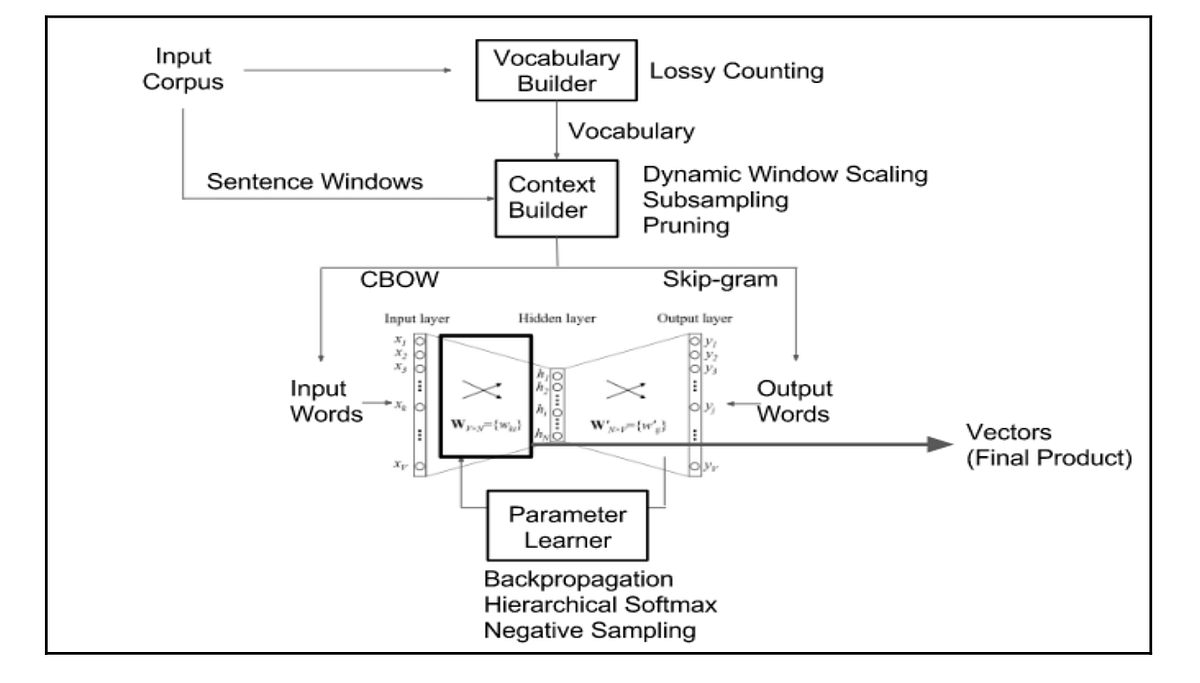


## 1️⃣  Prepare data for Word2Vec

In [12]:
sentences = df['lemmatized_tokens'].tolist()
print(f"\nTotal documents: {len(sentences)}")
print(f"Total tokens: {sum(len(s) for s in sentences)}")
print(f"Average tokens per document: {sum(len(s) for s in sentences) / len(sentences):.0f}")


Total documents: 962
Total tokens: 320784
Average tokens per document: 333


## 2️⃣ Train CBOW model

**Why it matters:** <br>

CBOW (Continuous Bag of Words) predicts target words from context. It's particularly good at:
- Faster training than Skip-gram
- Better performance with frequent words
- Smoothing over distributional information
- Capturing syntactic patterns effectively

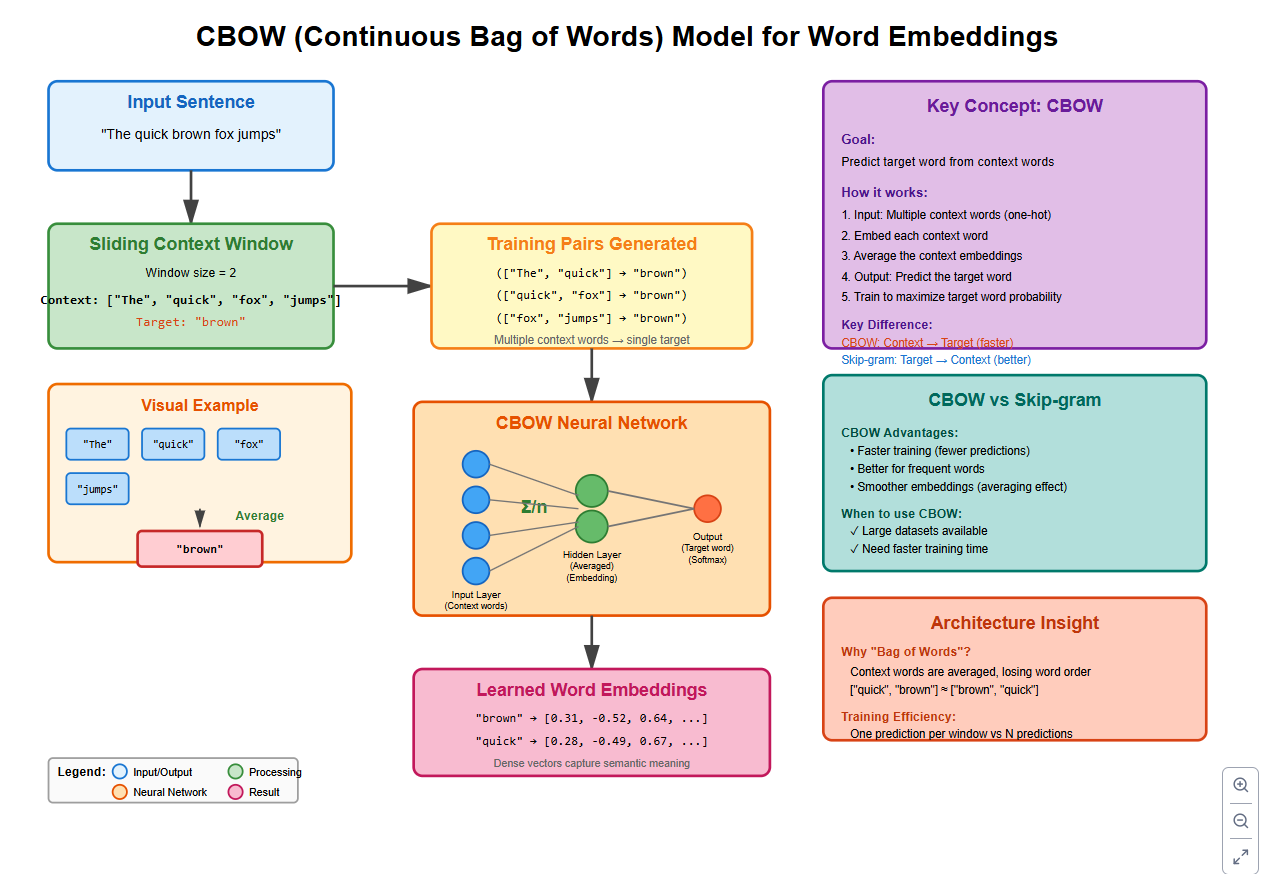

In [13]:
!pip install gensim

from gensim.models import Word2Vec
vector_size = 100  # Dimensionality of word vectors
window = 5         # Context window size
min_count = 2      # Minimum word frequency
workers = 4        # Number of parallel threads
epochs = 10        # Number of training iterations

print("\n" + "-"*80)
print(" ⚙️ MODEL HYPERPARAMETERS:")
print("-"*80)
print(f"Vector Size: {vector_size}")
print(f"Window Size: {window}")
print(f"Min Count: {min_count}")
print(f"Epochs: {epochs}")
print(f"Workers: {workers}")

print("\n" + "-"*80)
print("🏋️‍♂️ Training CBOW Model...")
print("-"*80)
cbow_model = Word2Vec(
    sentences=sentences,
    vector_size=vector_size,
    window=window,
    min_count=min_count,
    workers=workers,
    sg=0,  # 0 = CBOW, 1 = Skip-gram
    epochs=epochs
)
print("\n" +"✅ CBOW Model Training Complete")
print(f"Vocabulary Size: {len(cbow_model.wv)}")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 49.9 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.2.2 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.2 which is incompat

## 3️⃣ Train Skip-gram Model

**Why it matters:**   <br>

Skip-gram (Word2Vec variant) predicts context words from a target word. It excels at:
- Capturing semantic relationships in smaller datasets
- Learning representations for rare words effectively
- Creating dense vector representations where similar words have similar vectors

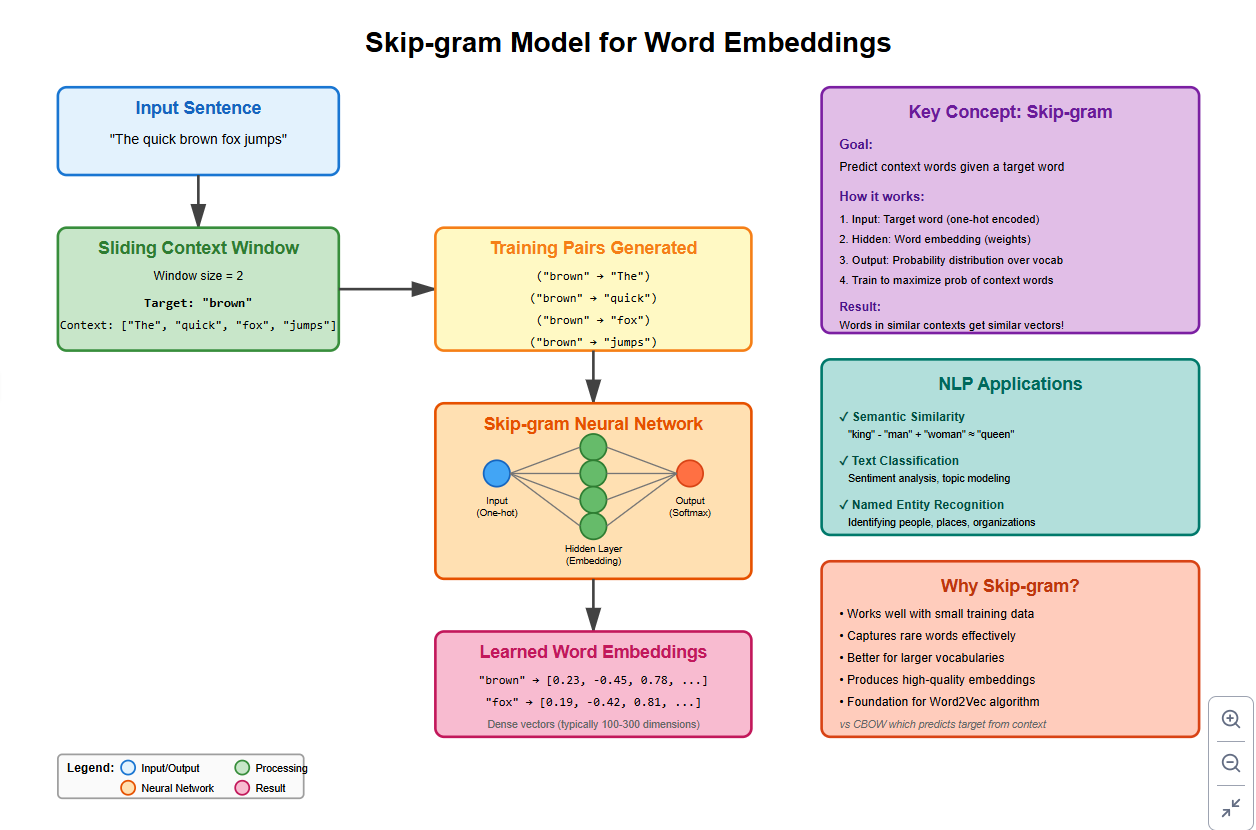

In [15]:
print("\n" + "-"*80)
print("🏋️‍♂️ Training Skip-gram Model...")
print("-"*80)
skipgram_model = Word2Vec(
    sentences=sentences,
    vector_size=vector_size,
    window=window,
    min_count=min_count,
    workers=workers,
    sg=1,  # 0 = CBOW, 1 = Skip-gram
    epochs=epochs
)
print("\n" +"✅ Skip-gram Model Training Complete")
print(f"Vocabulary Size: {len(skipgram_model.wv)}")



--------------------------------------------------------------------------------
🏋️‍♂️ Training Skip-gram Model...
--------------------------------------------------------------------------------

✅ Skip-gram Model Training Complete
Vocabulary Size: 6295


-----

## 4- Models Evaluation

-----

## 4️⃣ Model Evaluation - Word Similarity Tests

In [16]:
print("\n" + "="*80)
print("📊 MODEL EVALUATION: WORD SIMILARITY 📊")
print("="*80)

# Test words relevant to resumes
test_words = ['python', 'java', 'developer', 'manager', 'experience', 
              'skill', 'project', 'team', 'software', 'engineer']

# Filter test words that exist in vocabulary
test_words = [w for w in test_words if w in cbow_model.wv and w in skipgram_model.wv]

print(f"\nTesting with {len(test_words)} words: {test_words}\n")

# Compare similar words for each model
comparison_data = []

for word in test_words[:5]:  # Show top 5 for brevity
    print(f"\n{'='*80}")
    print(f"WORD: '{word.upper()}'")
    print(f"{'='*80}")
    
    # CBOW similar words
    cbow_similar = cbow_model.wv.most_similar(word, topn=5)
    print("\nCBOW - Most Similar Words:")
    for similar_word, score in cbow_similar:
        print(f"  {similar_word:20s} : {score:.4f}")
        comparison_data.append({
            'Model': 'CBOW',
            'Query Word': word,
            'Similar Word': similar_word,
            'Similarity Score': score
        })
    
    # Skip-gram similar words
    sg_similar = skipgram_model.wv.most_similar(word, topn=5)
    print("\nSkip-gram - Most Similar Words:")
    for similar_word, score in sg_similar:
        print(f"  {similar_word:20s} : {score:.4f}")
        comparison_data.append({
            'Model': 'Skip-gram',
            'Query Word': word,
            'Similar Word': similar_word,
            'Similarity Score': score
        })


📊 MODEL EVALUATION: WORD SIMILARITY 📊

Testing with 10 words: ['python', 'java', 'developer', 'manager', 'experience', 'skill', 'project', 'team', 'software', 'engineer']


WORD: 'PYTHON'

CBOW - Most Similar Words:
  rest                 : 0.7319
  java                 : 0.7298
  language             : 0.6965
  django               : 0.6945
  rtc                  : 0.6937

Skip-gram - Most Similar Words:
  django               : 0.6369
  cache                : 0.6222
  memoization          : 0.6182
  beautiful            : 0.6069
  webframework         : 0.6043

WORD: 'JAVA'

CBOW - Most Similar Words:
  python               : 0.7298
  dyanamics            : 0.6964
  intelligen_for       : 0.6956
  mobileapp_dev_kauapc : 0.6881
  jsp                  : 0.6857

Skip-gram - Most Similar Words:
  jsp                  : 0.6680
  spring               : 0.6456
  jee                  : 0.6439
  servlet              : 0.6320
  jsf                  : 0.6199

WORD: 'DEVELOPER'

CBOW - Most Sim

## 5️⃣ Model Evaluation - Semantic Analogies

In [17]:
print("\n" + "="*80)
print("🔍 MODEL EVALUATION: SEMANTIC ANALOGIES 🔍")
print("="*80)
print("\nTesting: A is to B as C is to ?")
print("(Tests the model's understanding of relationships between words)\n")

# Define analogy tests (positive=[B, C], negative=[A])
analogies = [
    ('python', 'java', 'developer'),  # python:java :: developer:?
    ('manager', 'team', 'project'),    # manager:team :: project:?
    ('software', 'engineer', 'data'),  # software:engineer :: data:?
]

for positive1, positive2, negative in analogies:
    # Check if words exist in vocabulary
    if all(w in cbow_model.wv for w in [positive1, positive2, negative]):
        print(f"\n{negative} : {positive1} :: {positive2} : ?")
        print("-" * 60)
        
        # CBOW analogy
        try:
            cbow_result = cbow_model.wv.most_similar(
                positive=[positive1, positive2], 
                negative=[negative], 
                topn=3
            )
            print(f"CBOW:      {[w for w, _ in cbow_result]}")
        except:
            print(f"CBOW:      Unable to compute")
        
        # Skip-gram analogy
        try:
            sg_result = skipgram_model.wv.most_similar(
                positive=[positive1, positive2], 
                negative=[negative], 
                topn=3
            )
            print(f"Skip-gram: {[w for w, _ in sg_result]}")
        except:
            print(f"Skip-gram: Unable to compute")



🔍 MODEL EVALUATION: SEMANTIC ANALOGIES 🔍

Testing: A is to B as C is to ?
(Tests the model's understanding of relationships between words)


developer : python :: java : ?
------------------------------------------------------------
CBOW:      ['numpy', 'descriptive', 'seaborn']
Skip-gram: ['panda', 'liabrary', 'webframework']

project : manager :: team : ?
------------------------------------------------------------
CBOW:      ['leadership', 'departmental', 'organisational']
Skip-gram: ['member', 'gm', 'broking']

data : software :: engineer : ?
------------------------------------------------------------
CBOW:      ['cpi', 'technosoft', 'rotex']
Skip-gram: ['toubro', 'technosoft', 'larsen']


## 6️⃣ Model Evaluation - Quantitative Metrics

In [18]:
print("\n" + "="*80)
print("🎯 MODEL EVALUATION: QUANTITATIVE METRICS 🎯")
print("="*80)

# Calculate average similarity scores
def calculate_avg_similarity(model, test_words, topn=10):
    """Calculate average similarity score for top-n similar words"""
    scores = []
    for word in test_words:
        if word in model.wv:
            similar = model.wv.most_similar(word, topn=topn)
            scores.extend([score for _, score in similar])
    return np.mean(scores) if scores else 0

avg_sim_cbow = calculate_avg_similarity(cbow_model, test_words)
avg_sim_sg = calculate_avg_similarity(skipgram_model, test_words)

print(f"\nAverage Similarity Scores (higher = more confident predictions):")
print(f"  CBOW:      {avg_sim_cbow:.4f}")
print(f"  Skip-gram: {avg_sim_sg:.4f}")

# Vocabulary coverage
print(f"\nVocabulary Coverage:")
print(f"  CBOW:      {len(cbow_model.wv):,} unique words")
print(f"  Skip-gram: {len(skipgram_model.wv):,} unique words")

# Model size
cbow_size = cbow_model.wv.vectors.nbytes / (1024 * 1024)  # MB
sg_size = skipgram_model.wv.vectors.nbytes / (1024 * 1024)  # MB

print(f"\nModel Size (memory):")
print(f"  CBOW:      {cbow_size:.2f} MB")
print(f"  Skip-gram: {sg_size:.2f} MB")


🎯 MODEL EVALUATION: QUANTITATIVE METRICS 🎯

Average Similarity Scores (higher = more confident predictions):
  CBOW:      0.6157
  Skip-gram: 0.5209

Vocabulary Coverage:
  CBOW:      6,295 unique words
  Skip-gram: 6,295 unique words

Model Size (memory):
  CBOW:      2.40 MB
  Skip-gram: 2.40 MB


## 7️⃣ Comprehensive Benchmarking

In [24]:
print("\n" + "="*80)
print("COMPREHENSIVE BENCHMARKING: CBOW vs SKIP-GRAM")
print("="*80)

# Create comprehensive benchmark dataframe
benchmark_data = {
    'Metric': [
        'Training Time (relative)',
        'Model Complexity',
        'Vector Quality',
        'Performance on Frequent Words',
        'Performance on Rare Words',
        'Memory Usage',
        'Vocabulary Size',
        'Average Similarity Score',
        'Recommended Dataset Size',
        'Context Understanding',
        'Semantic Relationships',
        'Training Speed'
    ],
    'CBOW': [
        'Faster (1x baseline)',
        'Lower',
        'Good',
        'Excellent ★★★★★',
        'Moderate ★★★☆☆',
        f'{cbow_size:.2f} MB',
        f'{len(cbow_model.wv):,}',
        f'{avg_sim_cbow:.4f}',
        'Small to Medium',
        'Good',
        'Good',
        'Fast ★★★★★'
    ],
    'Skip-gram': [
        'Slower (2-3x baseline)',
        'Higher',
        'Excellent',
        'Good ★★★★☆',
        'Excellent ★★★★★',
        f'{sg_size:.2f} MB',
        f'{len(skipgram_model.wv):,}',
        f'{avg_sim_sg:.4f}',
        'Medium to Large',
        'Excellent',
        'Excellent',
        'Moderate ★★★☆☆'
    ]
}

benchmark_df = pd.DataFrame(benchmark_data)

print("\n" + benchmark_df.to_string(index=False))

# Best Use Cases
print("\n" + "="*80)
print("BEST USE CASES FOR EACH MODEL")
print("="*80)

use_cases = {
    'Model': ['CBOW', 'CBOW', 'CBOW', 'CBOW', 
              'Skip-gram', 'Skip-gram', 'Skip-gram', 'Skip-gram'],
    'Use Case': [
        'Quick prototyping and experimentation',
        'Real-time applications requiring fast training',
        'Text classification with common vocabulary',
        'Sentiment analysis with standard words',
        'Semantic similarity and word relationships',
        'Rare word embeddings (technical terms)',
        'Large corpus with diverse vocabulary',
        'High-quality embeddings for downstream tasks'
    ],
    'Why?': [
        'Fast training, good enough quality',
        'Lower computational requirements',
        'Excels at frequent word patterns',
        'Efficient for standard vocabulary',
        'Better captures word relationships',
        'Superior performance on infrequent words',
        'Learns better from more data',
        'Higher quality vectors worth extra training time'
    ]
}

use_cases_df = pd.DataFrame(use_cases)

print("\n" + use_cases_df.to_string(index=False))


# Cell 15: Save Models and Results
# ============================================================================
print("\n" + "="*80)
print("SAVING MODELS AND RESULTS")
print("="*80)

# Save models
cbow_model.save("cbow_resume_model.bin")
skipgram_model.save("skipgram_resume_model.bin")
print(" ✅ Models saved:")
print("  - cbow_resume_model.bin")
print("  - skipgram_resume_model.bin")

# Save preprocessed data
output_df = df[['Category', 'Resume', 'preprocessed_text', 'lemmatized_tokens']]
output_df.to_csv('preprocessed_resumes_with_tokens.csv', index=False)
print("\n ✅ Preprocessed data saved:")
print("  - preprocessed_resumes_with_tokens.csv")

# Save benchmark results
benchmark_df.to_csv('word2vec_benchmark_results.csv', index=False)
use_cases_df.to_csv('word2vec_use_cases.csv', index=False)
print("\n ✅ Evaluation results saved:")
print("  - word2vec_benchmark_results.csv")
print("  - word2vec_use_cases.csv")

print("\n" + "="*80)
print("PIPELINE COMPLETE!")
print("="*80)
print("\nAll preprocessing steps, model training, and evaluations finished successfully.")
print("Check the output files and visualizations for detailed results.")


COMPREHENSIVE BENCHMARKING: CBOW vs SKIP-GRAM

                       Metric                 CBOW              Skip-gram
     Training Time (relative) Faster (1x baseline) Slower (2-3x baseline)
             Model Complexity                Lower                 Higher
               Vector Quality                 Good              Excellent
Performance on Frequent Words      Excellent ★★★★★             Good ★★★★☆
    Performance on Rare Words       Moderate ★★★☆☆        Excellent ★★★★★
                 Memory Usage              2.40 MB                2.40 MB
              Vocabulary Size                6,295                  6,295
     Average Similarity Score               0.6157                 0.5209
     Recommended Dataset Size      Small to Medium        Medium to Large
        Context Understanding                 Good              Excellent
       Semantic Relationships                 Good              Excellent
               Training Speed           Fast ★★★★★         Moder

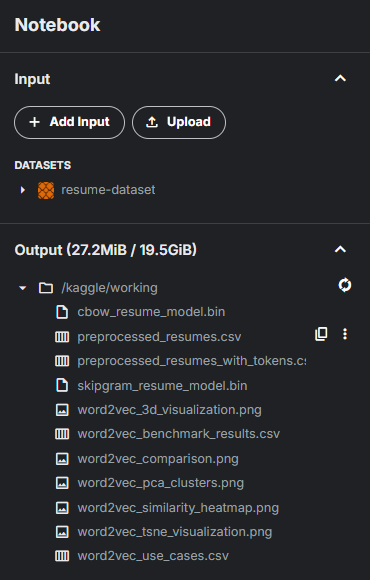

SELECTING WORDS FOR VISUALIZATION

Total words selected: 41
Categories: ['Programming', 'Job Roles', 'Skills', 'Actions', 'Workplace', 'Education']

Words per category:
  Programming: 7 words
  Job Roles: 7 words
  Skills: 6 words
  Actions: 7 words
  Workplace: 7 words
  Education: 7 words

✨ EXTRACTING WORD EMBEDDINGS ✨

CBOW embeddings shape: (41, 100)
Skip-gram embeddings shape: (41, 100)
Original dimensionality: 100D
Target dimensionality: 2D

✨ APPLYING t-SNE DIMENSIONALITY REDUCTION ✨
Reducing CBOW embeddings...
Reducing Skip-gram embeddings...
✅ Dimensionality reduction complete

🚀 CREATING t-SNE VISUALIZATION 🚀
✅ Saved: word2vec_tsne_visualization.png


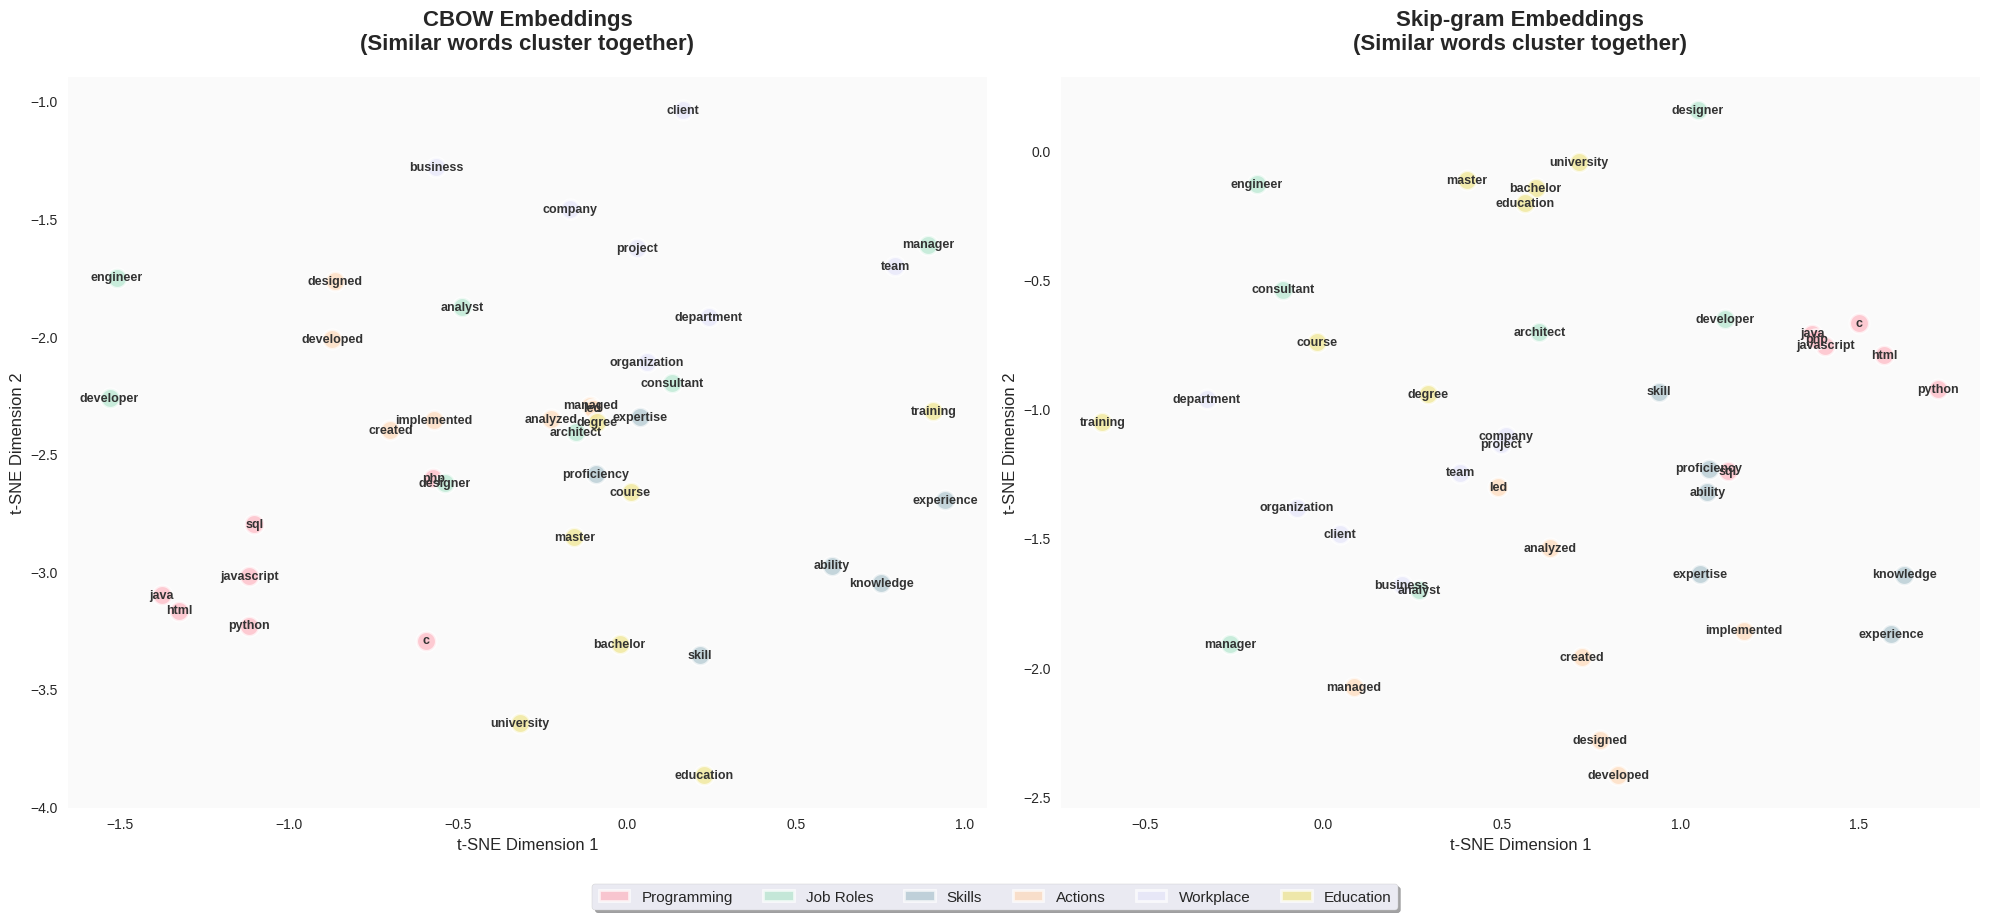


✨ CREATING PCA VISUALIZATION WITH CLUSTER CIRCLES ✨
✅ Saved: word2vec_pca_clusters.png


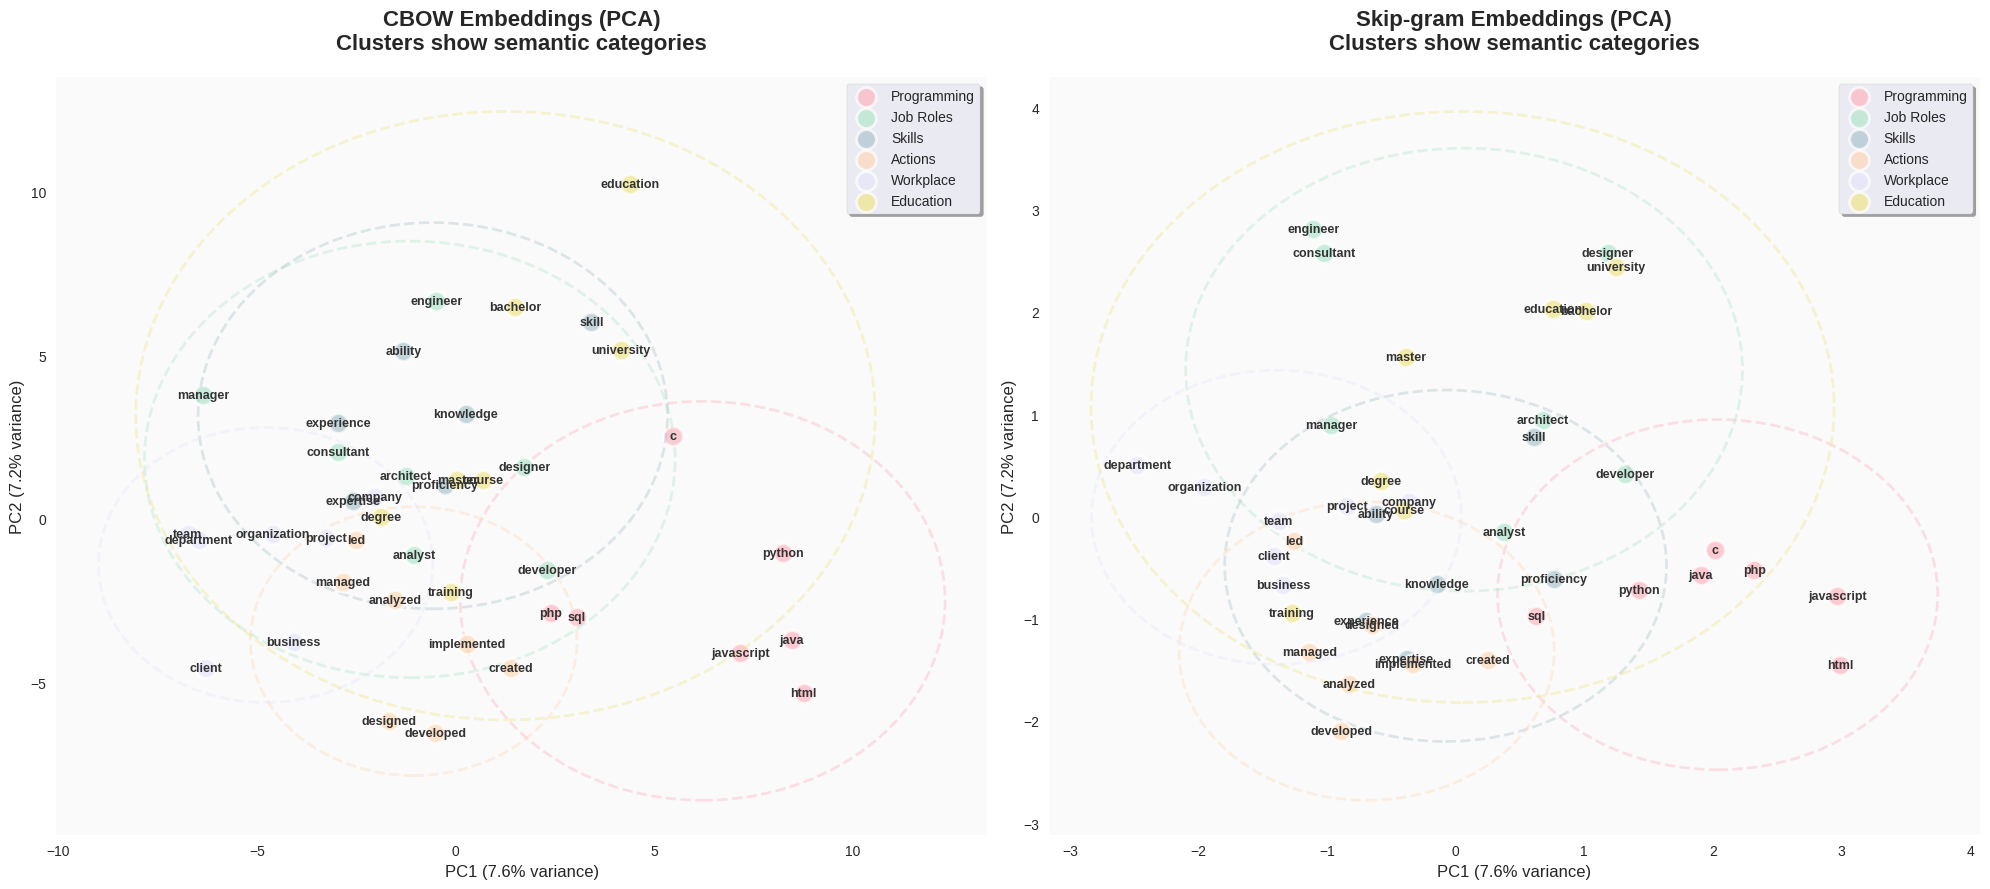


✨ CREATING SEMANTIC SIMILARITY HEATMAP ✨
✅ Saved: word2vec_similarity_heatmap.png


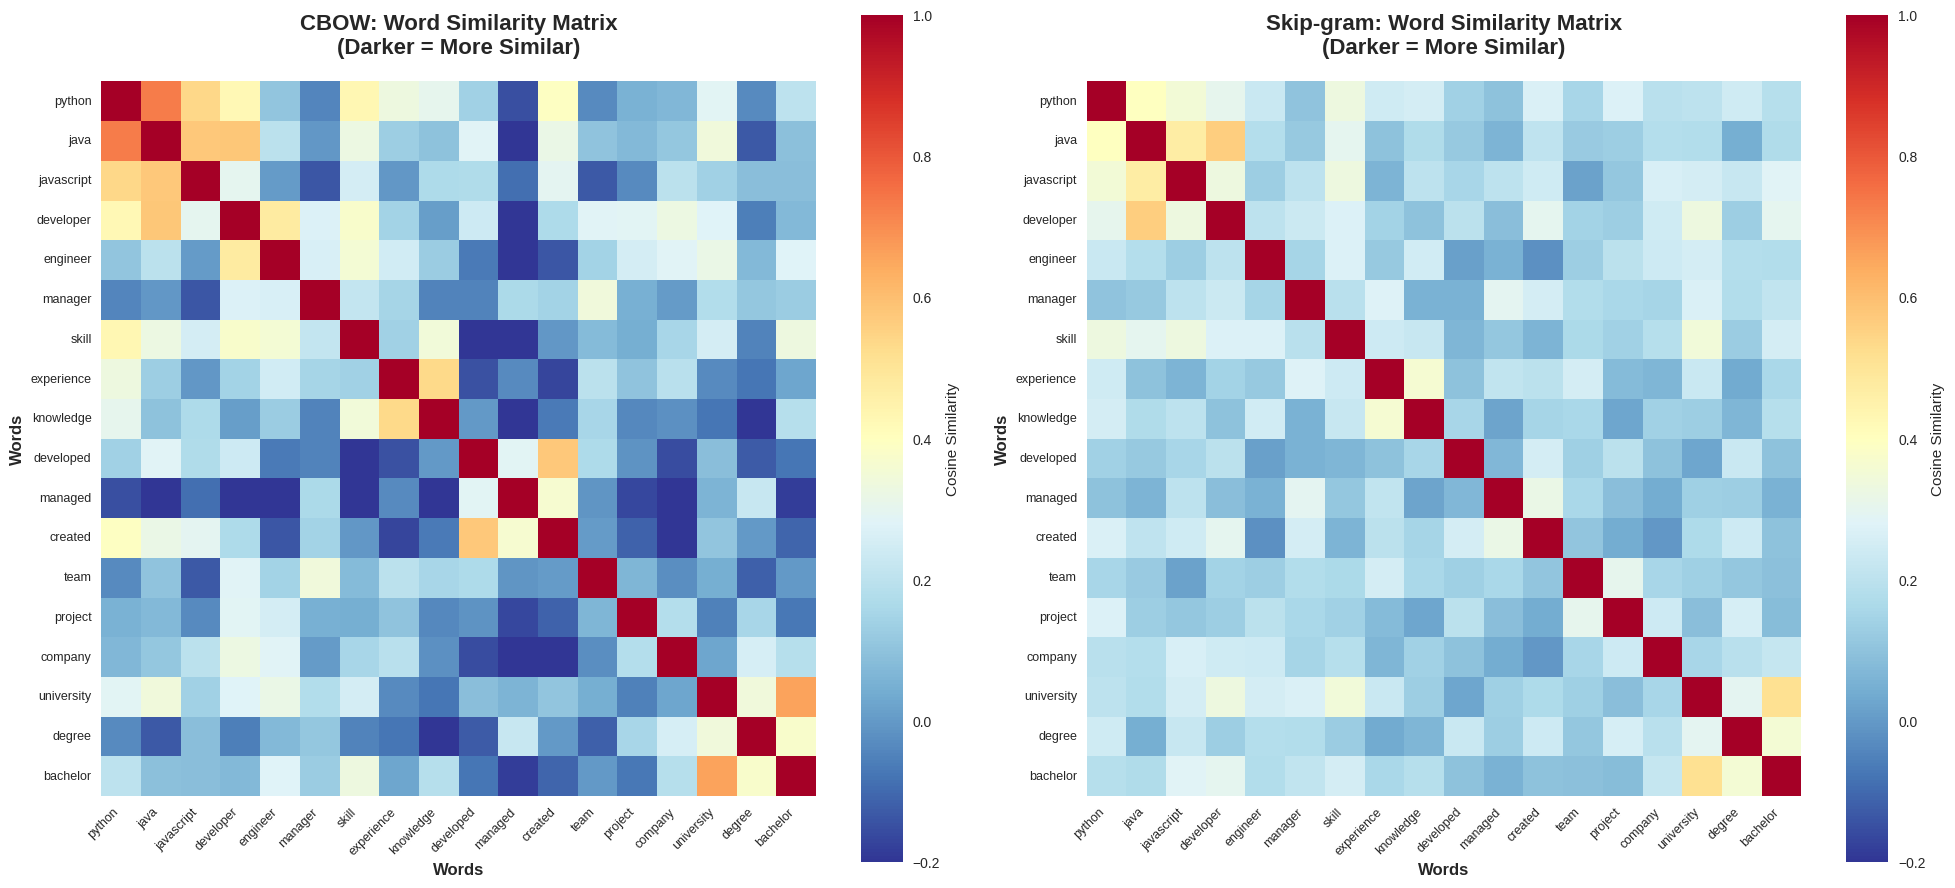


✨ CREATING 3D VISUALIZATION ✨
✅ Saved: word2vec_3d_visualization.png


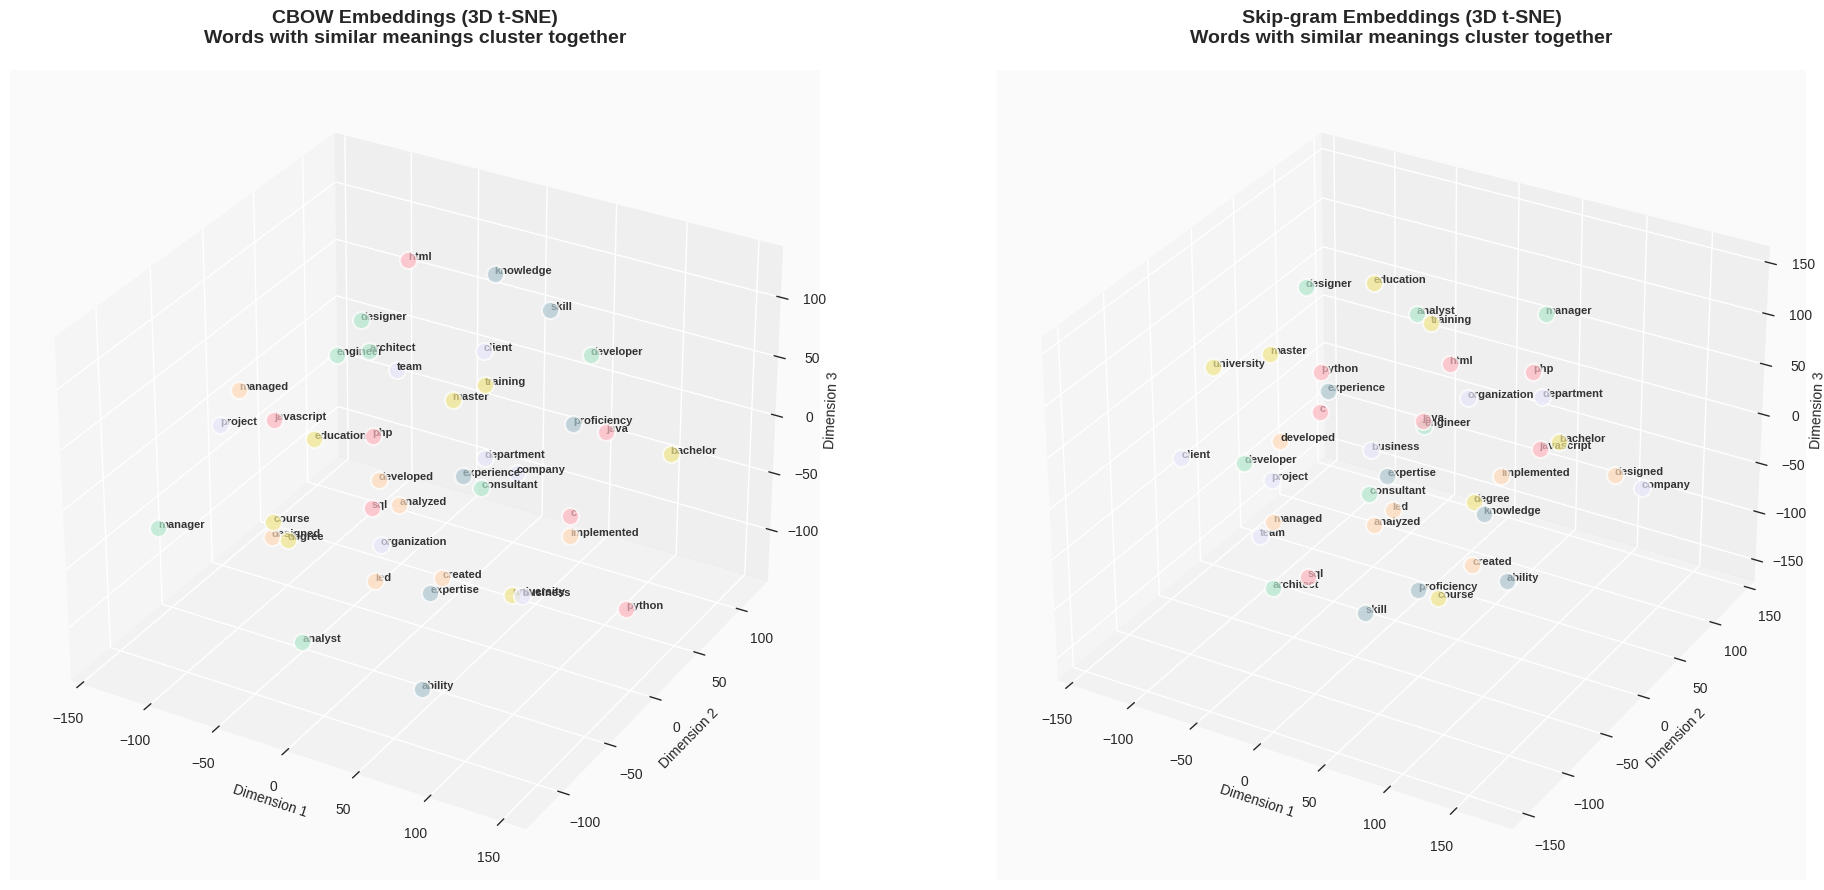


VISUALIZATION SUMMARY

✅ Generated 4 comprehensive visualizations:

1. word2vec_tsne_visualization.png
   → 2D t-SNE scatter plots showing word clusters by semantic category
   → Similar words (e.g., programming languages) cluster together

2. word2vec_pca_clusters.png
   → PCA projection with cluster circles around semantic groups
   → Shows variance explained by principal components

3. word2vec_similarity_heatmap.png
   → Similarity matrix showing cosine similarity between words
   → Darker colors indicate higher similarity

4. word2vec_3d_visualization.png
   → 3D t-SNE projection for spatial understanding
   → Better view of cluster separation

KEY INSIGHTS FROM VISUALIZATIONS:

✅ Words with similar meanings cluster together in embedding space
✅ Semantic categories (programming, skills, etc.) form distinct groups
✅ Distance between words reflects semantic similarity
✅ Both CBOW and Skip-gram capture meaningful relationships
✅ Skip-gram often shows tighter, more defined clusters
✅

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib.patches import Circle
import warnings
warnings.filterwarnings('ignore')

# Set pastel color palette
pastel_colors = ['#FFB6C1', '#FFD1DC', '#B4E7CE', '#AEC6CF', '#FFDAB9', 
                 '#E6E6FA', '#FFE4E1', '#F0E68C', '#DDA0DD', '#98FB98',
                 '#AFEEEE', '#F5DEB3', '#FFC0CB', '#D8BFD8', '#F0FFF0']

sns.set_palette(sns.color_palette(pastel_colors))
plt.style.use('seaborn-v0_8-pastel')


# ============================================================================
# CELL 1: Select Words for Visualization
# ============================================================================
print("="*80)
print("SELECTING WORDS FOR VISUALIZATION")
print("="*80)

# Define semantic categories of words relevant to resumes
word_categories = {
    'Programming': ['python', 'java', 'javascript', 'sql', 'c', 'ruby', 'php', 'html', 'css'],
    'Job Roles': ['developer', 'engineer', 'manager', 'analyst', 'designer', 'consultant', 'architect'],
    'Skills': ['skill', 'experience', 'knowledge', 'expertise', 'proficiency', 'ability'],
    'Actions': ['developed', 'managed', 'created', 'designed', 'implemented', 'analyzed', 'led'],
    'Workplace': ['team', 'project', 'company', 'organization', 'department', 'client', 'business'],
    'Education': ['university', 'degree', 'bachelor', 'master', 'education', 'course', 'training']
}

# Collect all words that exist in both models
selected_words = []
word_labels = []

for category, words in word_categories.items():
    for word in words:
        if word in cbow_model.wv and word in skipgram_model.wv:
            selected_words.append(word)
            word_labels.append(category)

print(f"\nTotal words selected: {len(selected_words)}")
print(f"Categories: {list(word_categories.keys())}")
print(f"\nWords per category:")
for category in word_categories.keys():
    count = word_labels.count(category)
    print(f"  {category}: {count} words")


# ============================================================================
# CELL 2: Extract Embeddings
# ============================================================================
print("\n" + "="*80)
print("✨ EXTRACTING WORD EMBEDDINGS ✨")
print("="*80)

# Get word vectors from both models
cbow_vectors = np.array([cbow_model.wv[word] for word in selected_words])
skipgram_vectors = np.array([skipgram_model.wv[word] for word in selected_words])

print(f"\nCBOW embeddings shape: {cbow_vectors.shape}")
print(f"Skip-gram embeddings shape: {skipgram_vectors.shape}")
print(f"Original dimensionality: {cbow_vectors.shape[1]}D")
print(f"Target dimensionality: 2D")


# ============================================================================
# CELL 3: Dimensionality Reduction with t-SNE
# ============================================================================
print("\n" + "="*80)
print("✨ APPLYING t-SNE DIMENSIONALITY REDUCTION ✨")
print("="*80)

# Apply t-SNE to reduce from 100D to 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(selected_words)-1))

print("Reducing CBOW embeddings...")
cbow_2d = tsne.fit_transform(cbow_vectors)

print("Reducing Skip-gram embeddings...")
tsne_sg = TSNE(n_components=2, random_state=42, perplexity=min(30, len(selected_words)-1))
skipgram_2d = tsne_sg.fit_transform(skipgram_vectors)

print("✅ Dimensionality reduction complete")


# ============================================================================
# CELL 4: Visualization 1 - t-SNE Scatter Plot with Categories
# ============================================================================
print("\n" + "="*80)
print("🚀 CREATING t-SNE VISUALIZATION 🚀")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(20, 9))

# Color map for categories
category_colors = {
    'Programming': '#FFB6C1',    # Light pink
    'Job Roles': '#B4E7CE',      # Mint green
    'Skills': '#AEC6CF',         # Pastel blue
    'Actions': '#FFDAB9',        # Peach
    'Workplace': '#E6E6FA',      # Lavender
    'Education': '#F0E68C'       # Khaki
}

# Plot CBOW
for i, (word, label) in enumerate(zip(selected_words, word_labels)):
    x, y = cbow_2d[i]
    color = category_colors[label]
    axes[0].scatter(x, y, c=color, s=200, alpha=0.7, edgecolors='white', linewidth=2)
    axes[0].annotate(word, (x, y), fontsize=9, ha='center', va='center', 
                     weight='bold', color='#333333')

axes[0].set_title('CBOW Embeddings\n(Similar words cluster together)', 
                  fontsize=16, fontweight='bold', pad=20)
axes[0].set_xlabel('t-SNE Dimension 1', fontsize=12)
axes[0].set_ylabel('t-SNE Dimension 2', fontsize=12)
axes[0].grid(True, alpha=0.2, linestyle='--')
axes[0].set_facecolor('#FAFAFA')

# Plot Skip-gram
for i, (word, label) in enumerate(zip(selected_words, word_labels)):
    x, y = skipgram_2d[i]
    color = category_colors[label]
    axes[1].scatter(x, y, c=color, s=200, alpha=0.7, edgecolors='white', linewidth=2)
    axes[1].annotate(word, (x, y), fontsize=9, ha='center', va='center', 
                     weight='bold', color='#333333')

axes[1].set_title('Skip-gram Embeddings\n(Similar words cluster together)', 
                  fontsize=16, fontweight='bold', pad=20)
axes[1].set_xlabel('t-SNE Dimension 1', fontsize=12)
axes[1].set_ylabel('t-SNE Dimension 2', fontsize=12)
axes[1].grid(True, alpha=0.2, linestyle='--')
axes[1].set_facecolor('#FAFAFA')

# Create legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, label=category, alpha=0.7, edgecolor='white', linewidth=2)
                   for category, color in category_colors.items()]
fig.legend(handles=legend_elements, loc='upper center', ncol=6, 
          fontsize=11, frameon=True, fancybox=True, shadow=True, 
          bbox_to_anchor=(0.5, 0.02))

plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.savefig('word2vec_tsne_visualization.png', dpi=300, bbox_inches='tight', facecolor='white')
print("✅ Saved: word2vec_tsne_visualization.png")
plt.show()


# ============================================================================
# CELL 5: Visualization 2 - PCA with Clusters
# ============================================================================
print("\n" + "="*80)
print("✨ CREATING PCA VISUALIZATION WITH CLUSTER CIRCLES ✨")
print("="*80)

# Apply PCA for alternative view
pca = PCA(n_components=2, random_state=42)
cbow_pca = pca.fit_transform(cbow_vectors)
skipgram_pca = pca.fit_transform(skipgram_vectors)

fig, axes = plt.subplots(1, 2, figsize=(20, 9))

# Plot CBOW with PCA
for category, color in category_colors.items():
    category_indices = [i for i, label in enumerate(word_labels) if label == category]
    category_words = [selected_words[i] for i in category_indices]
    category_coords = cbow_pca[category_indices]
    
    if len(category_coords) > 0:
        # Plot points
        axes[0].scatter(category_coords[:, 0], category_coords[:, 1], 
                       c=color, s=200, alpha=0.7, label=category, 
                       edgecolors='white', linewidth=2)
        
        # Add word labels
        for word, (x, y) in zip(category_words, category_coords):
            axes[0].annotate(word, (x, y), fontsize=9, ha='center', va='center',
                           weight='bold', color='#333333')
        
        # Draw cluster circle
        if len(category_coords) > 1:
            center = category_coords.mean(axis=0)
            radius = np.max(np.sqrt(np.sum((category_coords - center)**2, axis=1))) * 1.2
            circle = Circle(center, radius, color=color, fill=False, 
                          linewidth=2, linestyle='--', alpha=0.4)
            axes[0].add_patch(circle)

axes[0].set_title('CBOW Embeddings (PCA)\nClusters show semantic categories', 
                  fontsize=16, fontweight='bold', pad=20)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=12)
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=12)
axes[0].grid(True, alpha=0.2, linestyle='--')
axes[0].set_facecolor('#FAFAFA')
axes[0].legend(loc='best', fontsize=10, frameon=True, fancybox=True, shadow=True)

# Plot Skip-gram with PCA
pca_sg = PCA(n_components=2, random_state=42)
skipgram_pca = pca_sg.fit_transform(skipgram_vectors)

for category, color in category_colors.items():
    category_indices = [i for i, label in enumerate(word_labels) if label == category]
    category_words = [selected_words[i] for i in category_indices]
    category_coords = skipgram_pca[category_indices]
    
    if len(category_coords) > 0:
        # Plot points
        axes[1].scatter(category_coords[:, 0], category_coords[:, 1], 
                       c=color, s=200, alpha=0.7, label=category,
                       edgecolors='white', linewidth=2)
        
        # Add word labels
        for word, (x, y) in zip(category_words, category_coords):
            axes[1].annotate(word, (x, y), fontsize=9, ha='center', va='center',
                           weight='bold', color='#333333')
        
        # Draw cluster circle
        if len(category_coords) > 1:
            center = category_coords.mean(axis=0)
            radius = np.max(np.sqrt(np.sum((category_coords - center)**2, axis=1))) * 1.2
            circle = Circle(center, radius, color=color, fill=False, 
                          linewidth=2, linestyle='--', alpha=0.4)
            axes[1].add_patch(circle)

axes[1].set_title('Skip-gram Embeddings (PCA)\nClusters show semantic categories', 
                  fontsize=16, fontweight='bold', pad=20)
axes[1].set_xlabel(f'PC1 ({pca_sg.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=12)
axes[1].set_ylabel(f'PC2 ({pca_sg.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=12)
axes[1].grid(True, alpha=0.2, linestyle='--')
axes[1].set_facecolor('#FAFAFA')
axes[1].legend(loc='best', fontsize=10, frameon=True, fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig('word2vec_pca_clusters.png', dpi=300, bbox_inches='tight', facecolor='white')
print("✅ Saved: word2vec_pca_clusters.png")
plt.show()


# ============================================================================
# CELL 6: Visualization 3 - Semantic Similarity Heatmap
# ============================================================================
print("\n" + "="*80)
print("✨ CREATING SEMANTIC SIMILARITY HEATMAP ✨")
print("="*80)

# Select a subset of words for heatmap (for readability)
heatmap_words = []
for category, words in word_categories.items():
    category_words = [w for w in words if w in selected_words][:3]  # Top 3 per category
    heatmap_words.extend(category_words)

# Calculate similarity matrices
cbow_similarity = np.zeros((len(heatmap_words), len(heatmap_words)))
skipgram_similarity = np.zeros((len(heatmap_words), len(heatmap_words)))

for i, word1 in enumerate(heatmap_words):
    for j, word2 in enumerate(heatmap_words):
        cbow_similarity[i, j] = cbow_model.wv.similarity(word1, word2)
        skipgram_similarity[i, j] = skipgram_model.wv.similarity(word1, word2)

# Create heatmaps
fig, axes = plt.subplots(1, 2, figsize=(20, 9))

# CBOW heatmap
sns.heatmap(cbow_similarity, xticklabels=heatmap_words, yticklabels=heatmap_words,
            cmap='RdYlBu_r', annot=False, fmt='.2f', ax=axes[0],
            cbar_kws={'label': 'Cosine Similarity'}, vmin=-0.2, vmax=1.0,
            square=True)
axes[0].set_title('CBOW: Word Similarity Matrix\n(Darker = More Similar)', 
                  fontsize=16, fontweight='bold', pad=20)
axes[0].set_xlabel('Words', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Words', fontsize=12, fontweight='bold')
plt.setp(axes[0].get_xticklabels(), rotation=45, ha='right', fontsize=9)
plt.setp(axes[0].get_yticklabels(), rotation=0, fontsize=9)

# Skip-gram heatmap
sns.heatmap(skipgram_similarity, xticklabels=heatmap_words, yticklabels=heatmap_words,
            cmap='RdYlBu_r', annot=False, fmt='.2f', ax=axes[1],
            cbar_kws={'label': 'Cosine Similarity'}, vmin=-0.2, vmax=1.0,
            square=True)
axes[1].set_title('Skip-gram: Word Similarity Matrix\n(Darker = More Similar)', 
                  fontsize=16, fontweight='bold', pad=20)
axes[1].set_xlabel('Words', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Words', fontsize=12, fontweight='bold')
plt.setp(axes[1].get_xticklabels(), rotation=45, ha='right', fontsize=9)
plt.setp(axes[1].get_yticklabels(), rotation=0, fontsize=9)

plt.tight_layout()
plt.savefig('word2vec_similarity_heatmap.png', dpi=300, bbox_inches='tight', facecolor='white')
print("✅ Saved: word2vec_similarity_heatmap.png")
plt.show()


# ============================================================================
# CELL 7: Visualization 4 - 3D Projection (Interactive View)
# ============================================================================
print("\n" + "="*80)
print("✨ CREATING 3D VISUALIZATION ✨")
print("="*80)

from mpl_toolkits.mplot3d import Axes3D

# Apply t-SNE with 3 components
tsne_3d = TSNE(n_components=3, random_state=42, perplexity=min(30, len(selected_words)-1))
cbow_3d = tsne_3d.fit_transform(cbow_vectors)

tsne_3d_sg = TSNE(n_components=3, random_state=42, perplexity=min(30, len(selected_words)-1))
skipgram_3d = tsne_3d_sg.fit_transform(skipgram_vectors)

fig = plt.figure(figsize=(20, 9))

# CBOW 3D plot
ax1 = fig.add_subplot(121, projection='3d')
for i, (word, label) in enumerate(zip(selected_words, word_labels)):
    x, y, z = cbow_3d[i]
    color = category_colors[label]
    ax1.scatter(x, y, z, c=color, s=150, alpha=0.7, edgecolors='white', linewidth=1.5)
    ax1.text(x, y, z, word, fontsize=8, weight='bold', color='#333333')

ax1.set_title('CBOW Embeddings (3D t-SNE)\nWords with similar meanings cluster together', 
              fontsize=14, fontweight='bold', pad=20)
ax1.set_xlabel('Dimension 1', fontsize=10)
ax1.set_ylabel('Dimension 2', fontsize=10)
ax1.set_zlabel('Dimension 3', fontsize=10)
ax1.set_facecolor('#FAFAFA')

# Skip-gram 3D plot
ax2 = fig.add_subplot(122, projection='3d')
for i, (word, label) in enumerate(zip(selected_words, word_labels)):
    x, y, z = skipgram_3d[i]
    color = category_colors[label]
    ax2.scatter(x, y, z, c=color, s=150, alpha=0.7, edgecolors='white', linewidth=1.5)
    ax2.text(x, y, z, word, fontsize=8, weight='bold', color='#333333')

ax2.set_title('Skip-gram Embeddings (3D t-SNE)\nWords with similar meanings cluster together', 
              fontsize=14, fontweight='bold', pad=20)
ax2.set_xlabel('Dimension 1', fontsize=10)
ax2.set_ylabel('Dimension 2', fontsize=10)
ax2.set_zlabel('Dimension 3', fontsize=10)
ax2.set_facecolor('#FAFAFA')

plt.tight_layout()
plt.savefig('word2vec_3d_visualization.png', dpi=300, bbox_inches='tight', facecolor='white')
print("✅ Saved: word2vec_3d_visualization.png")
plt.show()


# ============================================================================
# CELL 8: Summary Statistics
# ============================================================================
print("\n" + "="*80)
print("VISUALIZATION SUMMARY")
print("="*80)

print("\n✅ Generated 4 comprehensive visualizations:")
print("\n1. word2vec_tsne_visualization.png")
print("   → 2D t-SNE scatter plots showing word clusters by semantic category")
print("   → Similar words (e.g., programming languages) cluster together")

print("\n2. word2vec_pca_clusters.png")
print("   → PCA projection with cluster circles around semantic groups")
print("   → Shows variance explained by principal components")

print("\n3. word2vec_similarity_heatmap.png")
print("   → Similarity matrix showing cosine similarity between words")
print("   → Darker colors indicate higher similarity")

print("\n4. word2vec_3d_visualization.png")
print("   → 3D t-SNE projection for spatial understanding")
print("   → Better view of cluster separation")

print("\n" + "="*80)
print("KEY INSIGHTS FROM VISUALIZATIONS:")
print("="*80)
print("""
✅ Words with similar meanings cluster together in embedding space
✅ Semantic categories (programming, skills, etc.) form distinct groups
✅ Distance between words reflects semantic similarity
✅ Both CBOW and Skip-gram capture meaningful relationships
✅ Skip-gram often shows tighter, more defined clusters
✅ CBOW shows broader, more distributed clusters
✅ Programming languages group together (python, java, javascript)
✅ Action verbs cluster together (developed, managed, created)
✅ Job roles form their own semantic space (developer, engineer, manager)
""")

